In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Reload the line

In [3]:
line = xt.Line.from_json('pimms_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


## Power extraction sextupoles

In [4]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

### Moved analysis from the previous code into a function

In [5]:
from phase_space_characterization import characterize_phase_space_at_septum

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


<IPython.core.display.Javascript object>


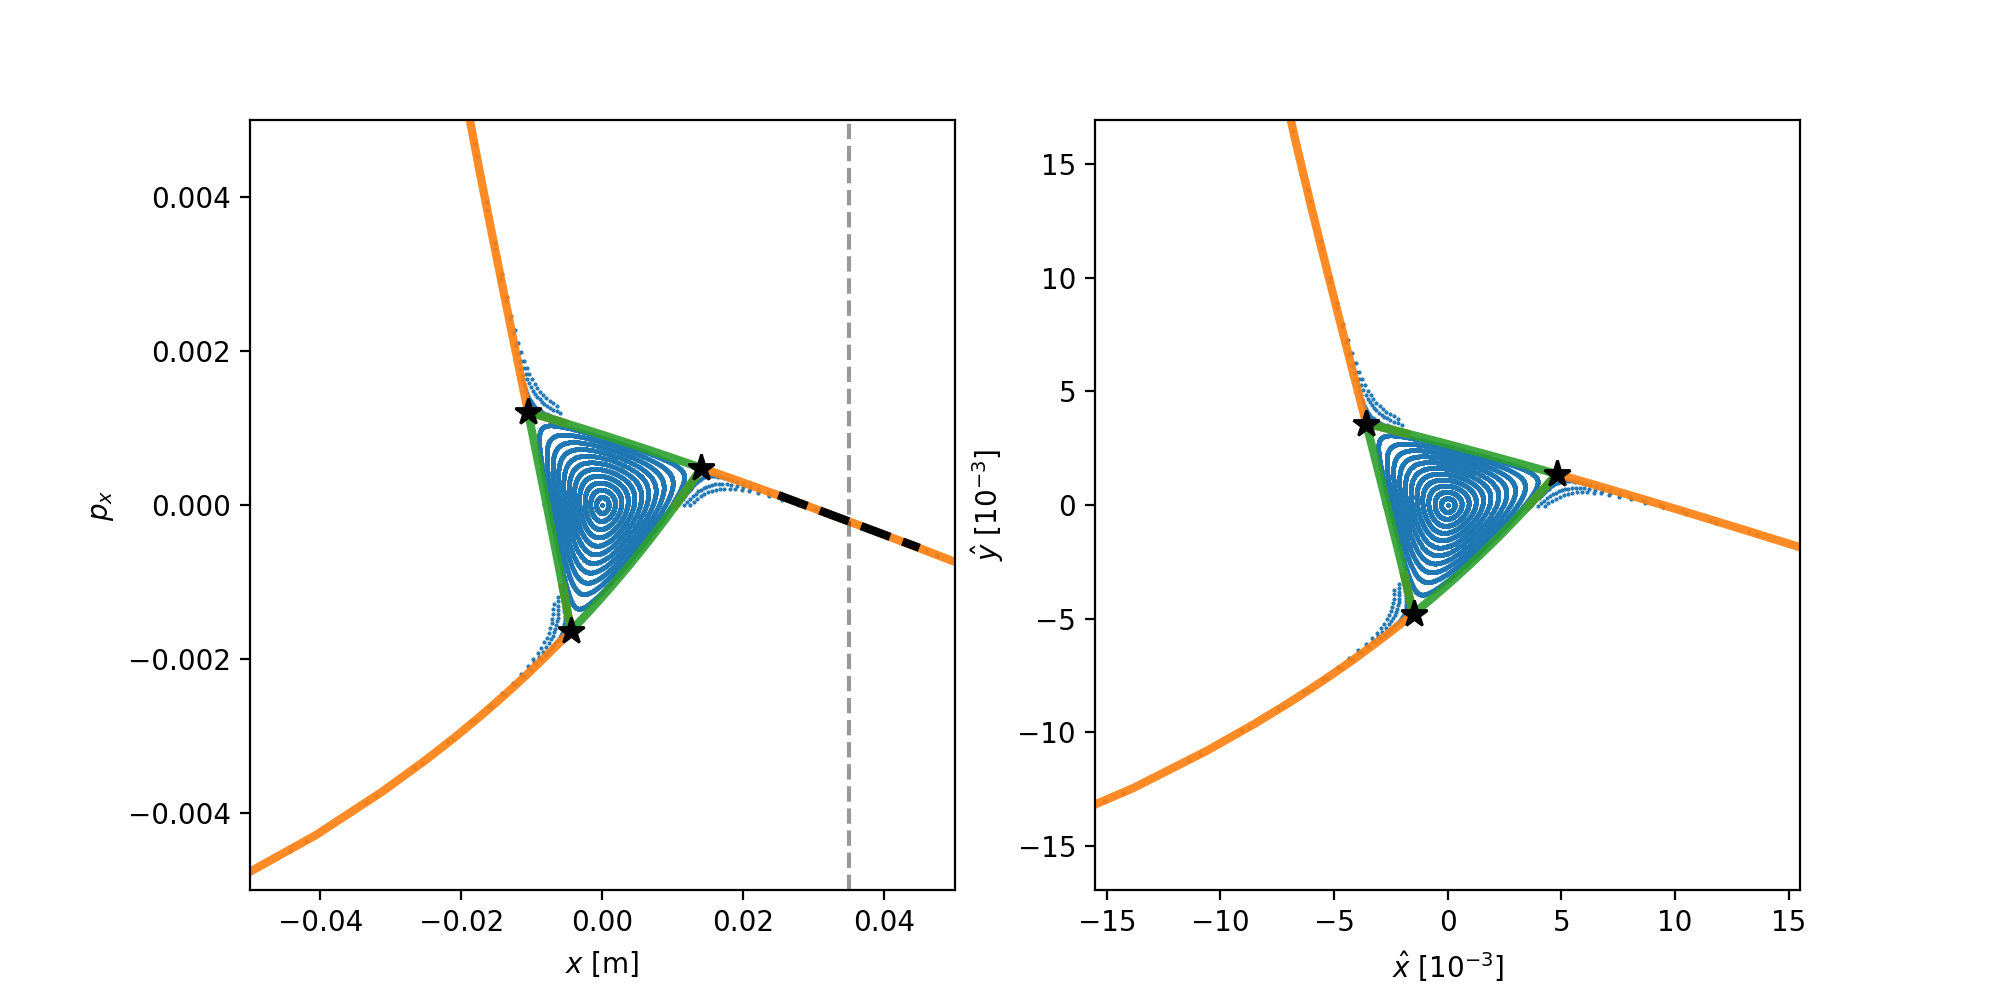

{'dpx_dx_at_septum': -0.03424216378131333,
 'stable_area': 6.535784095893052e-05,
 'x_fp': array([-0.01052962, -0.00442366,  0.01406426]),
 'px_fp': array([-0.01052962, -0.00442366,  0.01406426]),
 'x_norm_fp': array([-0.00358398, -0.00150569,  0.00478707]),
 'px_norm_fp': array([-0.00358398, -0.00150569,  0.00478707])}

In [6]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [7]:
# Time the chracterization function (with no plot)
%time res = characterize_phase_space_at_septum(line, num_turns=1000)

CPU times: user 362 ms, sys: 1.16 s, total: 1.52 s
Wall time: 197 ms


## Resonance optimization

In [10]:
# To use the results from our function in an optimization
# we need to wrap the function in an Action class

class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out
    
# Build the action
action = ActionSeparatrix(line)

In [11]:
# From the action we can create optimization targets

opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [12]:
opt.target_status()

Target status:                          
id state tag tol_met      residue current_val target_val description                                 
 0 ON          False -3.46421e-05 6.53579e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON          False   -0.0642422  -0.0342422       0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


In [ ]:
def err_fun(x):
    out = opt._err(x, check_limits=False)
    #print(f'x = {repr(x)}, out = {out}')
    return out

bounds = np.array([vv.limits for vv in opt._err.vary])
opt._err.return_scalar = True
import pybobyqa
soln = pybobyqa.solve(err_fun, x0=opt.log().vary[0, :], bounds=bounds.T,
            rhobeg=5, rhoend=1e-4, maxfun=30, objfun_has_noise=True,
            seek_global_minimum=True)
err_fun(soln.x) # set it to found solution
opt.tag('pybobyqa') # Add point to optimization log
opt.target_status()

In [ ]:
opt.log()

In [ ]:
opt.vary_status()

In [ ]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [ ]:
line.to_json('pimms_02_tuned.json')